In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
import gc
import matplotlib.font_manager as fm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei')  # 解决Seaborn中文显示问题
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

由于CSV文件内数据超过4千万笔，Pandas DataFrame无法一次读取这么大的数据量，因此将CSV文件内的数据每100万笔读取一次，然后从这100万笔中随机抽取5%的数据，形成一个新的训练集

In [2]:
chunksize = 10 ** 6
num_of_chunk = 0
train = pd.DataFrame()
    
for chunk in pd.read_csv('train.csv', chunksize=chunksize):
    num_of_chunk += 1
    train = pd.concat([train, chunk.sample(frac=.05, replace=False, random_state=37)], axis=0)
    print('Processing Chunk No. ' + str(num_of_chunk))     
    
train.reset_index(inplace=True)

# 备份原始训练集的数据长度，方便后续重新分割索引
train_len = len(train)
train_len

Processing Chunk No. 1
Processing Chunk No. 2
Processing Chunk No. 3
Processing Chunk No. 4
Processing Chunk No. 5
Processing Chunk No. 6
Processing Chunk No. 7
Processing Chunk No. 8
Processing Chunk No. 9
Processing Chunk No. 10
Processing Chunk No. 11
Processing Chunk No. 12
Processing Chunk No. 13
Processing Chunk No. 14
Processing Chunk No. 15
Processing Chunk No. 16
Processing Chunk No. 17
Processing Chunk No. 18
Processing Chunk No. 19
Processing Chunk No. 20
Processing Chunk No. 21
Processing Chunk No. 22
Processing Chunk No. 23
Processing Chunk No. 24
Processing Chunk No. 25
Processing Chunk No. 26
Processing Chunk No. 27
Processing Chunk No. 28
Processing Chunk No. 29
Processing Chunk No. 30
Processing Chunk No. 31
Processing Chunk No. 32
Processing Chunk No. 33
Processing Chunk No. 34
Processing Chunk No. 35
Processing Chunk No. 36
Processing Chunk No. 37
Processing Chunk No. 38
Processing Chunk No. 39
Processing Chunk No. 40
Processing Chunk No. 41


2021448

将test测试集的资料读出后，把train训练集和 test测试集合并成新的数据集df，方便同时对资料集进行数据预处理。

In [3]:
test_file = 'test.gz'
df = pd.concat([train, pd.read_csv(test_file, compression='gzip')]).drop(['index', 'id'], axis=1)


本次预测的目的为用10天的点击情况作为训练模型，用来预测第11天的点击情况，因此年月日期没有参考价值，但是weekday有参考价值。所以把原始数据中hour特征中的日期，转化为weekday。
每天的小时段根据每人不同的生活习惯，有参考价值。为避免24小时的纬度导致数据崩溃，采用十二地支计时法将小时的区间分为12个时辰，每两小時一个时辰。

In [4]:
# 定义一个将hour数据转换为日期格式的函数
def get_date(hour):
    y = '20'+str(hour)[:2]
    m = str(hour)[2:4]
    d = str(hour)[4:6]
    return y+'-'+m+'-'+d

# 创建weekday列，将hour数据转换后填入
df['weekday'] = pd.to_datetime(df.hour.apply(get_date)).dt.dayofweek.astype(str)

# 定义一个将hour数据转换为12时辰的函数
def tran_hour(x):
    x = x % 100
    while x in [23,0]:
        return '1'
    while x in [1,2]:
        return '2'
    while x in [3,4]:
        return '3'
    while x in [5,6]:
        return '4'
    while x in [7,8]:
        return '5'
    while x in [9,10]:
        return '6'
    while x in [11,12]:
        return '7'
    while x in [13,14]:
        return '8'
    while x in [15,16]:
        return '9'
    while x in [17,18]:
        return '10'
    while x in [19,20]:
        return '1'
    while x in [21,22]:
        return '12'
    

# 将hour列的数据转换为时段
df['hour'] = df.hour.apply(tran_hour)

In [5]:
# 查看数据集的的简要摘要
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6598912 entries, 0 to 4577463
Data columns (total 24 columns):
 #   Column            Dtype  
---  ------            -----  
 0   click             float64
 1   hour              object 
 2   C1                int64  
 3   banner_pos        int64  
 4   site_id           object 
 5   site_domain       object 
 6   site_category     object 
 7   app_id            object 
 8   app_domain        object 
 9   app_category      object 
 10  device_id         object 
 11  device_ip         object 
 12  device_model      object 
 13  device_type       int64  
 14  device_conn_type  int64  
 15  C14               int64  
 16  C15               int64  
 17  C16               int64  
 18  C17               int64  
 19  C18               int64  
 20  C19               int64  
 21  C20               int64  
 22  C21               int64  
 23  weekday           object 
dtypes: float64(1), int64(12), object(11)
memory usage: 1.2+ GB


In [6]:
df.head(20)

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday
0,1.0,3,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,0,15708,320,50,1722,0,35,100083,79,1
1,0.0,3,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,0,15701,320,50,1722,0,35,-1,79,1
2,0.0,3,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,0,15699,320,50,1722,0,35,-1,79,1
3,0.0,4,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,0,15706,320,50,1722,0,35,100084,79,1
4,0.0,1,1005,0,6256f5b4,28f93029,f028772b,ecad2386,7801e8d9,07d7df22,...,0,20366,320,50,2333,0,39,-1,157,1
5,0.0,2,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,...,0,17614,320,50,1993,2,1063,100084,33,1
6,0.0,3,1005,0,78d60190,1b32ed33,70fb0e29,ecad2386,7801e8d9,07d7df22,...,0,20003,320,50,2282,3,35,-1,117,1
7,1.0,2,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,0,15699,320,50,1722,0,35,100084,79,1
8,0.0,2,1005,0,85f751fd,c4e18dd6,50e219e0,39947756,2347f47a,cef3e649,...,2,21647,320,50,2487,1,547,-1,51,1
9,0.0,3,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,0f2161f8,...,0,21611,320,50,2480,3,299,100111,61,1


In [7]:
df.isnull().any()  #查看缺失值情况

click                True
hour                False
C1                  False
banner_pos          False
site_id             False
site_domain         False
site_category       False
app_id              False
app_domain          False
app_category        False
device_id           False
device_ip           False
device_model        False
device_type         False
device_conn_type    False
C14                 False
C15                 False
C16                 False
C17                 False
C18                 False
C19                 False
C20                 False
C21                 False
weekday             False
dtype: bool

确认每个特征的计数值，int类别的特征，最多包含4333个特征值，在这个新生成的600万笔数据的资料集，既然不是连续计数，据此判定本资料集的所有特征均为Object类型的数值。

In [8]:
len_of_feature_count = []
for i in df.columns[2:23].tolist():
    print(i, ':', len(df[i].astype(str).value_counts()))
    len_of_feature_count.append(len(df[i].astype(str).value_counts()))

C1 : 7
banner_pos : 7
site_id : 3501
site_domain : 4304
site_category : 25
app_id : 5456
app_domain : 309
app_category : 29
device_id : 553513
device_ip : 1876695
device_model : 6302
device_type : 4
device_conn_type : 4
C14 : 2662
C15 : 8
C16 : 9
C17 : 467
C18 : 4
C19 : 68
C20 : 167
C21 : 62


In [9]:
df.columns

Index(['click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'weekday'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6598912 entries, 0 to 4577463
Data columns (total 24 columns):
 #   Column            Dtype  
---  ------            -----  
 0   click             float64
 1   hour              object 
 2   C1                int64  
 3   banner_pos        int64  
 4   site_id           object 
 5   site_domain       object 
 6   site_category     object 
 7   app_id            object 
 8   app_domain        object 
 9   app_category      object 
 10  device_id         object 
 11  device_ip         object 
 12  device_model      object 
 13  device_type       int64  
 14  device_conn_type  int64  
 15  C14               int64  
 16  C15               int64  
 17  C16               int64  
 18  C17               int64  
 19  C18               int64  
 20  C19               int64  
 21  C20               int64  
 22  C21               int64  
 23  weekday           object 
dtypes: float64(1), int64(12), object(11)
memory usage: 1.2+ GB


In [11]:
df_describe = df.describe()
df_describe

,click,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,2.021448e+06,6.598912e+06,6.598912e+06,6.598912e+06,6.598912e+06,6.598912e+06,6.598912e+06,6.598912e+06,6.598912e+06,6.598912e+06,6.598912e+06,6.598912e+06,6.598912e+06
mean,1.699584e-01,1.004982e+03,2.345505e-01,1.011268e+00,3.615288e-01,2.083368e+04,3.198177e+02,5.972008e+01,2.359957e+03,1.343724e+00,1.980149e+02,5.338189e+04,8.932898e+01
std,3.755963e-01,9.838387e-01,4.839890e-01,4.606424e-01,8.839961e-01,4.374423e+03,2.664230e+01,4.676491e+01,5.457326e+02,1.313017e+00,2.930217e+02,4.994886e+04,8.010207e+01
min,0.000000e+00,1.001000e+03,0.000000e+00,0.000000e+00,0.000000e+00,3.750000e+02,1.200000e+02,2.000000e+01,1.120000e+02,0.000000e+00,3.300000e+01,-1.000000e+00,1.000000e+00
25%,0.000000e+00,1.005000e+03,0.000000e+00,1.000000e+00,0.000000e+00,1.977200e+04,3.200000e+02,5.000000e+01,2.227000e+03,0.000000e+00,3.500000e+01,-1.000000e+00,2.300000e+01
50%,0.000000e+00,1.005000e+03,0.000000e+00,1.000000e+00,0.000000e+00,2.226100e+04,3.200000e+02,5.000000e+01,2.545000e+03,1.000000e+00,3.900000e+01,1.000740e+05,5.100000e+01
75%,0.000000e+00,1.005000e+03,0.000000e+00,1.000000e+00,0.000000e+00,2.372500e+04,3.200000e+02,5.000000e+01,2.707000e+03,3.000000e+00,2.950000e+02,1.001110e+05,1.570000e+02
max,1.000000e+00,1.012000e+03,7.000000e+00,5.000000e+00,5.000000e+00,2.434900e+04,1.024000e+03,1.024000e+03,2.793000e+03,3.000000e+00,1.839000e+03,1.002480e+05,2.550000e+02


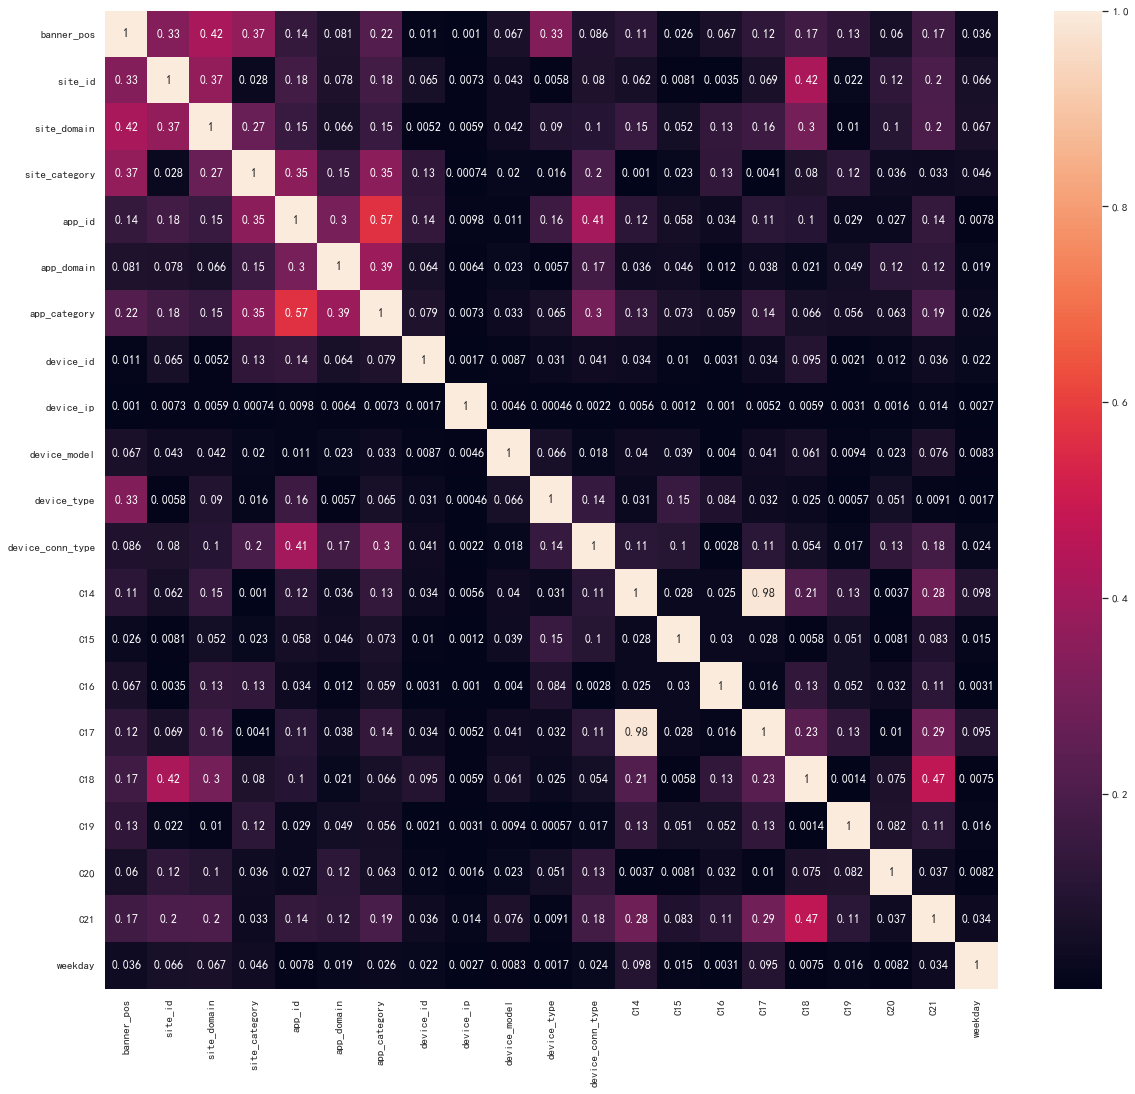

In [12]:
need_tran_feature = ['site_id', 'site_domain','site_category', 'app_id', 'app_domain', 'app_category','device_ip','device_model','device_id']
# 依次将非int类型的数据转换为int类型
df['weekday'] = df['weekday'].astype(str).astype(int)  
df['hour'] = df['hour'].astype(str).astype(int) 
for column in need_tran_feature:
    enc = LabelEncoder()
    df[column] = enc.fit_transform(df[column])
 #热力图   
sub_df = df.iloc[:, 3:]
plt.figure(figsize=(20, 18))
sns.heatmap(sub_df.corr().abs(), annot=True)
plt.show()

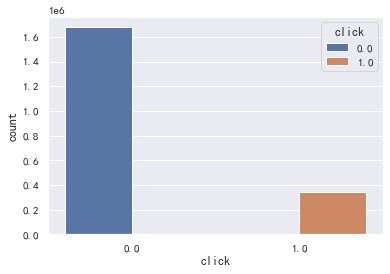

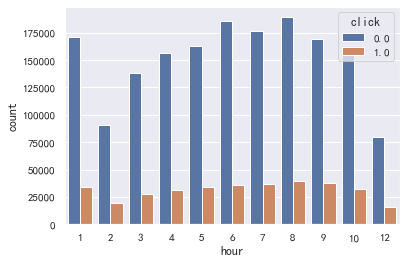

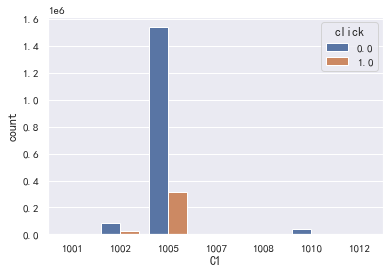

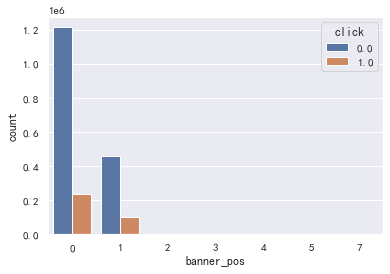

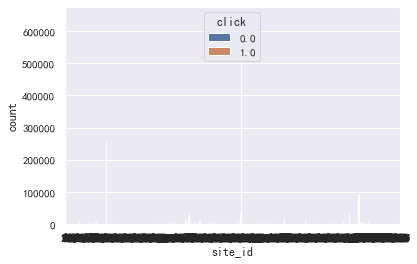

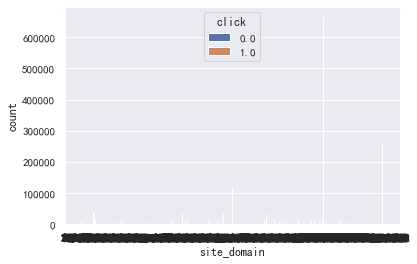

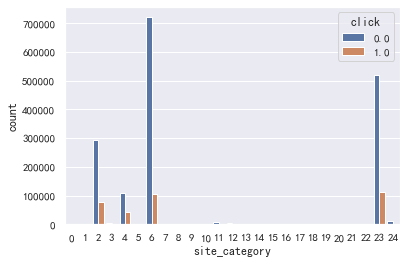

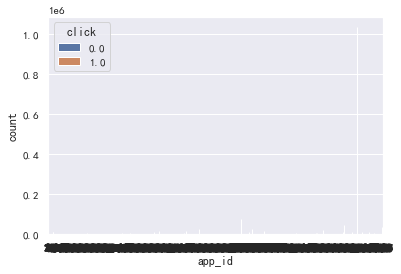

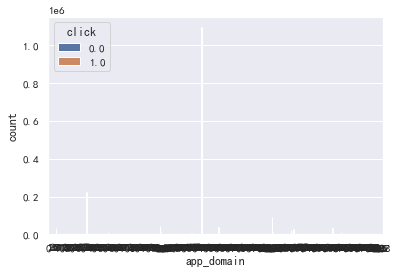

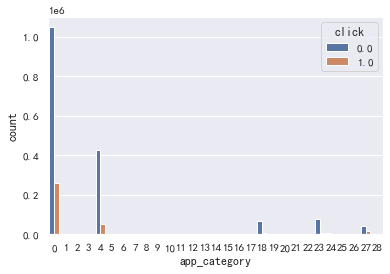

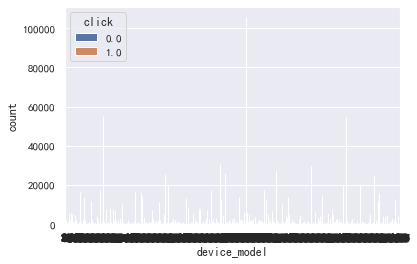

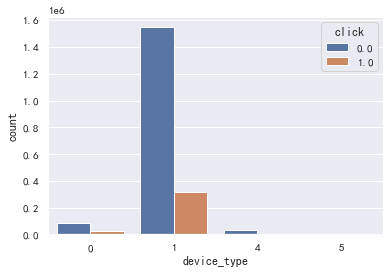

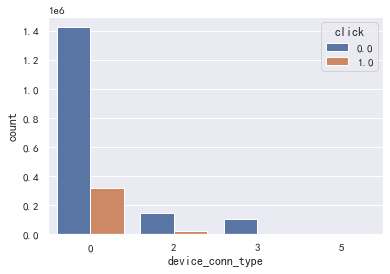

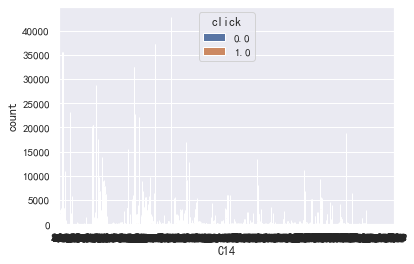

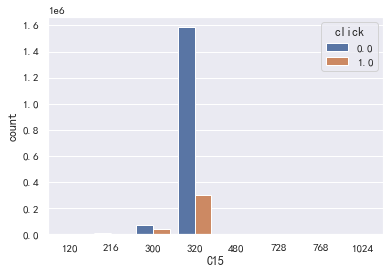

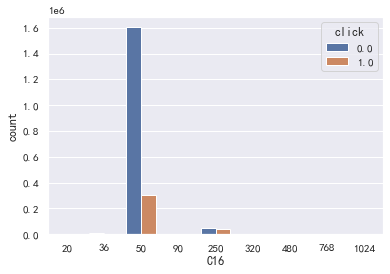

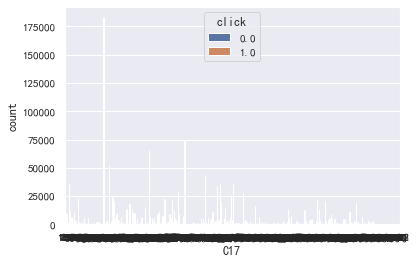

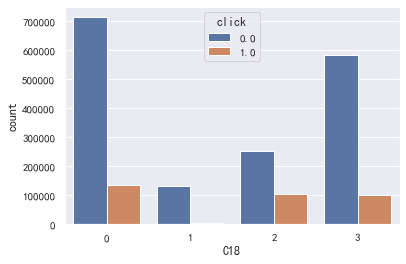

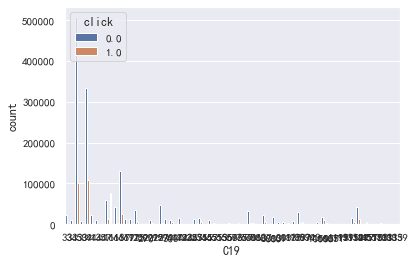

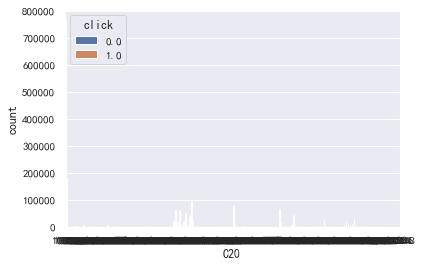

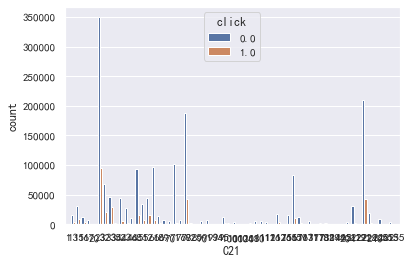

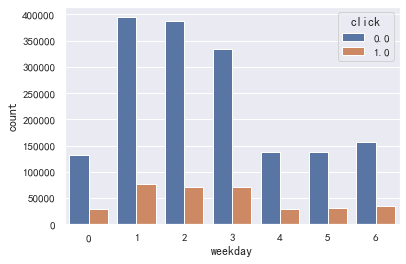

In [13]:
# 确认所有特征的分布情况
plt_features=['click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category',  'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'weekday']
for i in plt_features:
    sns.countplot(x = i, hue = "click", data = df)
    plt.show()

In [14]:
# 根据处理过的df资料集，重新將train训练集, test测试集分割出來
train = df[:train_len]
test = df[train_len:]

由于资料集的数据量非常的庞大，同时正向label的占比仅占全部资料的17%左右，比例明显失衡，需要用强化加权功能的演算法，因此决定使用微软的lightgbm演算法，解决强化权重问题

In [15]:
x=gc.collect()#释放内存
# 从train训练集中，标签为0的资料中，随机抽取与标签为1一样多的数量，并将其结合成正反标签各占50%的资料集
pre_X = train[train['click'] == 0].sample(n=len(train[train['click'] == 1]), random_state=37)
pre_X = pd.concat([pre_X, train[train['click'] == 1]]).sample(frac=1)
pre_y = pre_X[['click']]
pre_X.drop(['click'], axis=1, inplace=True)
test.drop(['click'], axis=1, inplace=True)

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [16]:
# 将新的资料集分割为训练集和验证集
X_train, X_test, y_train, y_test = train_test_split(pre_X, pre_y, test_size=0.20, stratify=pre_y, random_state=37)

In [17]:
clf = LGBMClassifier( 
        n_estimators=2000,
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        metric='auc',
        num_leaves=20,
    )
h = clf.fit(X_train,y_train,eval_set=[(X_test,y_test)],verbose=50,early_stopping_rounds=100)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.702218
[100]	valid_0's auc: 0.709815
[150]	valid_0's auc: 0.715355
[200]	valid_0's auc: 0.719456
[250]	valid_0's auc: 0.722052
[300]	valid_0's auc: 0.724263
[350]	valid_0's auc: 0.726016
[400]	valid_0's auc: 0.727612
[450]	valid_0's auc: 0.728888
[500]	valid_0's auc: 0.730108
[550]	valid_0's auc: 0.7312
[600]	valid_0's auc: 0.732072
[650]	valid_0's auc: 0.732867
[700]	valid_0's auc: 0.733585
[750]	valid_0's auc: 0.734235
[800]	valid_0's auc: 0.734829
[850]	valid_0's auc: 0.735453
[900]	valid_0's auc: 0.73597
[950]	valid_0's auc: 0.736412
[1000]	valid_0's auc: 0.736799
[1050]	valid_0's auc: 0.737153
[1100]	valid_0's auc: 0.737488
[1150]	valid_0's auc: 0.737789
[1200]	valid_0's auc: 0.738101
[1250]	valid_0's auc: 0.738396
[1300]	valid_0's auc: 0.738669
[1350]	valid_0's auc: 0.738937
[1400]	valid_0's auc: 0.739172
[1450]	valid_0's auc: 0.739455
[1500]	valid_0's auc: 0.739666
[1550]	valid_0's auc: 0.73991
[

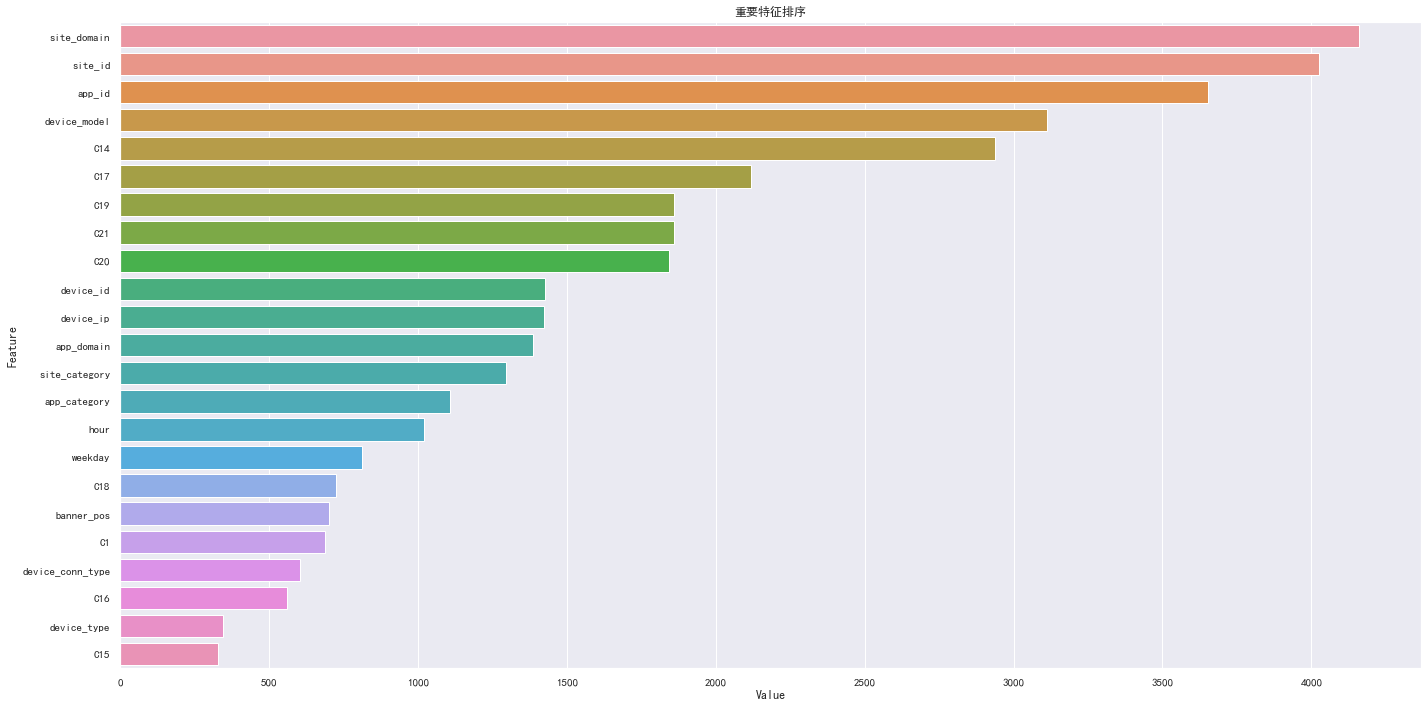

In [18]:
    feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X_train.columns)), columns=['Value','Feature'])
    plt.figure(figsize=(20, 10))
    #sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title("重要特征排序")
    plt.tight_layout()
    plt.show()

In [19]:
features = X_train.columns

feature_importance_values = clf.feature_importances_

feature_importances = pd.DataFrame({'feature': list(features), 'importance': feature_importance_values})

feature_importances.sort_values('importance', inplace=True, ascending=False)
print(feature_importances)

             feature  importance
4        site_domain        4161
3            site_id        4025
6             app_id        3653
11      device_model        3113
14               C14        2939
17               C17        2119
19               C19        1860
21               C21        1859
20               C20        1842
9          device_id        1426
10         device_ip        1424
7         app_domain        1388
5      site_category        1295
8       app_category        1107
0               hour        1020
22           weekday         811
18               C18         725
2         banner_pos         701
1                 C1         688
13  device_conn_type         606
16               C16         561
12       device_type         347
15               C15         330


Roc_auc_score:  68.2839245583395 %


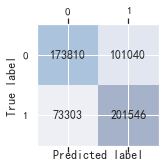

In [20]:
y_pred = clf.predict(X_train)
#y_pred = clf.predict(X)
print("Roc_auc_score: ",roc_auc_score(y_train,y_pred)*100,"%")

# 输出混淆矩阵，查看预测结果
confmat = confusion_matrix(y_true=y_train, y_pred=y_pred, labels=[0, 1])

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()



In [21]:
x=gc.collect()#释放内存